In [137]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from tqdm.auto import tqdm
import time
import numpy as np
import numpy.ma as ma

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from sklearn.model_selection import StratifiedKFold
from numpy.fft import fft, ifft
from tensorflow.keras.layers import Dense, Activation, Input, GRU, SimpleRNN, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform

In [138]:
# Helper code to get the action/subject from the path of the file
sensor_list = ['act', 'acw', 'dc', 'pm']
# Test out the read in helper function
def get_subject_action(sensor, full_path):
    index = full_path.find(sensor)
    index += len(sensor)
    subject = int(full_path[index+1:index+3])
    action = int(full_path[index+4:index+6])
    if action == 4:
        if full_path.find(f"{sensor}_1") > 0:
            action = '4-1'
        else:
            action = '4-2'
        
    return (subject, str(action))

for sensor in sensor_list:
    for sensor_dir in glob.iglob('.\\data\\' + sensor ):
        for subject_id, subject_dir in enumerate(glob.iglob(f"{sensor_dir}\\*")):
            for action_id, file in enumerate(os.listdir(subject_dir)):
                full_path = f"{subject_dir}\\{file}"

total_data = {
    'act': None,
    'acw': None,
    'dc': None,
    'pm': None,
}


headers = {
    'act': ['times', 'X', 'Y', 'Z'],
    'acw': ['times', 'X', 'Y', 'Z'],
    'dc': ['times'],
    'pm': ['times']
}
for i in range(1,513):
    headers['pm'].append(f"sensor_{i}")
for i in range(1,193):
    headers['dc'].append(f"sensor_{i}")

actions = ['1', '2', '3', '4-1', '4-2', '5', '6', '7']

sensor_list = ['act', 'acw', 'dc', 'pm']
#sensor_list = ['acw']

# there are 956 files in our dataset
i = 0

pbar = tqdm(desc="load data", total=956)
for sensor in sensor_list:
    for sensor_dir in glob.iglob('.\\data\\' + sensor ):
        #print(f"On {sensor}")
        for subject_id, subject_dir in enumerate(glob.iglob(f"{sensor_dir}\\*")):
            for action_id, file in enumerate(os.listdir(subject_dir)):
                full_path = f"{subject_dir}\\{file}"
                df_tmp = pd.read_csv(full_path, names=headers[sensor])
                i+=1
                pbar.update(1)
                subject, action = get_subject_action(sensor, full_path)
                # add one to make it match the given format
                df_tmp['subject'] = subject
                df_tmp['action'] = action
                if total_data[sensor] is None:
                    total_data[sensor] = df_tmp
                else:
                    total_data[sensor] = pd.concat([total_data[sensor], df_tmp])

load data:   0%|          | 0/956 [00:00<?, ?it/s]

# Try it on subject one action 1

In [61]:

subjects = range(1,31)
dc_X_cols = [f"sensor_{i}" for i in range(1,193)]
pm_X_cols = [f"sensor_{i}" for i in range(1,513)]
acw_X_cols = ["X", "Y", "Z"]

def batch_data(total_dfs, seconds=5, saved_off=[1,2]):
    samples100 = 100*seconds
    samples15 = 15*seconds
    df_acw = total_dfs['acw']
    df_act = total_dfs['act']
    df_dc = total_dfs['dc']
    df_pm = total_dfs['pm']
    
    all_cols = []
    for i in range(0, samples100):
        all_cols += [f"acw_{val}_{i}" for val in acw_X_cols]
    for i in range(0, samples15):
        all_cols += [f"dc_{val}_{i}" for val in dc_X_cols]
    for i in range(0, samples15):
        all_cols += [f"pm_{val}_{i}" for val in pm_X_cols]
    for i in range(0, samples100):
        all_cols += [f"act_{val}_{i}" for val in acw_X_cols]
    
    
    df_all = pd.DataFrame(columns=all_cols+['action'])
    df_saved = pd.DataFrame(columns=all_cols+['action'])
    
    actions = df_acw['action'].unique()
    pbar_steps = len(actions)*len(subjects)
    pbar = tqdm(desc="batch data", total=pbar_steps)
    
    for subject in subjects:
        actions = df_acw['action'].unique()
        for action in actions:
            X_acw = df_acw[(df_acw.subject == subject) & (df_acw.action == action)][acw_X_cols].to_numpy()
            X_acw = X_acw[range(0, (X_acw.shape[0]//samples100)*samples100)] # cut off records that don't fit in the window
            X_acw = np.reshape(X_acw, (X_acw.shape[0]//samples100, samples100*len(acw_X_cols)))
            
            X_dc = df_dc[(df_dc.subject == subject) & (df_dc.action == action)][dc_X_cols].to_numpy()
            X_dc = X_dc[range(0, (X_dc.shape[0]//samples15)*samples15)]
            X_dc = np.reshape(X_dc, (X_dc.shape[0]//samples15, samples15*len(dc_X_cols)))
            
            X_pm = df_pm[(df_pm.subject == subject) & (df_pm.action == action)][pm_X_cols].to_numpy()
            X_pm = X_pm[range(0, (X_pm.shape[0]//samples15)*samples15)]
            X_pm = np.reshape(X_pm, (X_pm.shape[0]//samples15, samples15*len(pm_X_cols)))
            
            X_act = df_act[(df_act.subject == subject) & (df_act.action == action)][acw_X_cols].to_numpy()
            X_act = X_act[range(0, (X_act.shape[0]//samples100)*samples100)]
            X_act = np.reshape(X_act, (X_act.shape[0]//samples100, samples100*len(acw_X_cols)))
            
            # trim to the smallest one of these 4
            num_records = min(X_acw.shape[0], X_act.shape[0], X_pm.shape[0], X_dc.shape[0])
            X_acw = X_acw[range(0,num_records)]
            X_dc = X_dc[range(0,num_records)]
            X_pm = X_pm[range(0,num_records)]
            X_act = X_act[range(0,num_records)]
            
            X_total = np.hstack((X_acw, X_dc, X_pm, X_act))
            
            df_tmp = pd.DataFrame(X_total, columns=all_cols)
            df_tmp['action'] = action
            if subject in saved_off:
                df_saved = pd.concat([df_saved, df_tmp])
            else:
                df_all = pd.concat([df_all, df_tmp])
            
            pbar.update(1)
            
    return (df_all, df_saved)

df_batched, df_batch_saved_off = batch_data(total_data, seconds=3)
df_batched.head()

batch data:   0%|          | 0/240 [00:00<?, ?it/s]

,acw_X_0,acw_Y_0,acw_Z_0,acw_X_1,acw_Y_1,acw_Z_1,acw_X_2,acw_Y_2,acw_Z_2,acw_X_3,...,act_X_297,act_Y_297,act_Z_297,act_X_298,act_Y_298,act_Z_298,act_X_299,act_Y_299,act_Z_299,action
0,-0.656250,-0.078125,0.687500,-0.656250,-0.078125,0.687500,-0.656250,-0.078125,0.68750,-0.656250,...,-0.750000,0.640625,-0.125000,-0.750000,0.625000,-0.140625,-0.750000,0.625000,-0.140625,1
1,-0.437500,-0.062500,0.812500,-0.453125,-0.062500,0.812500,-0.453125,-0.062500,0.81250,-0.453125,...,-0.703125,0.484375,-0.468750,-0.703125,0.468750,-0.468750,-0.703125,0.468750,-0.453125,1
2,-0.687500,0.015625,0.671875,-0.703125,0.015625,0.671875,-0.687500,0.015625,0.65625,-0.687500,...,-0.703125,0.484375,-0.421875,-0.718750,0.484375,-0.421875,-0.718750,0.453125,-0.437500,1
3,-0.625000,0.000000,0.718750,-0.625000,0.000000,0.718750,-0.640625,0.000000,0.71875,-0.640625,...,-0.687500,0.593750,-0.203125,-0.687500,0.609375,-0.203125,-0.703125,0.609375,-0.187500,1
4,-0.578125,0.046875,0.750000,-0.578125,0.046875,0.750000,-0.578125,0.046875,0.75000,-0.562500,...,-0.296875,0.109375,-0.890625,-0.265625,0.203125,-0.953125,-0.265625,0.109375,-0.921875,1


In [62]:
def plot_acc_data(df, subject, action, title=""):
    plt.figure(figsize=(100, 40))
    
    if type(df) == pd.core.frame.DataFrame:
        arr = df.to_numpy()
        
    arr =  arr[arr[:,5] == action]
    arr =  arr[arr[:,4] == subject]
    plt.plot(range(0,len(arr)),arr[:,1])
    plt.plot(range(0,len(arr)),arr[:,2])
    plt.plot(range(0,len(arr)),arr[:,3])
    plt.title(title,fontsize = 120)
    plt.show()

In [63]:
def plot_acc_data_numpy(x, y, z, title=""):
    plt.figure(figsize=(100, 40))
    
    plt.plot(range(0,len(x)),x)
    plt.plot(range(0,len(y)),y)
    plt.plot(range(0,len(z)),z)
    plt.title(title,fontsize = 120)
    plt.show()

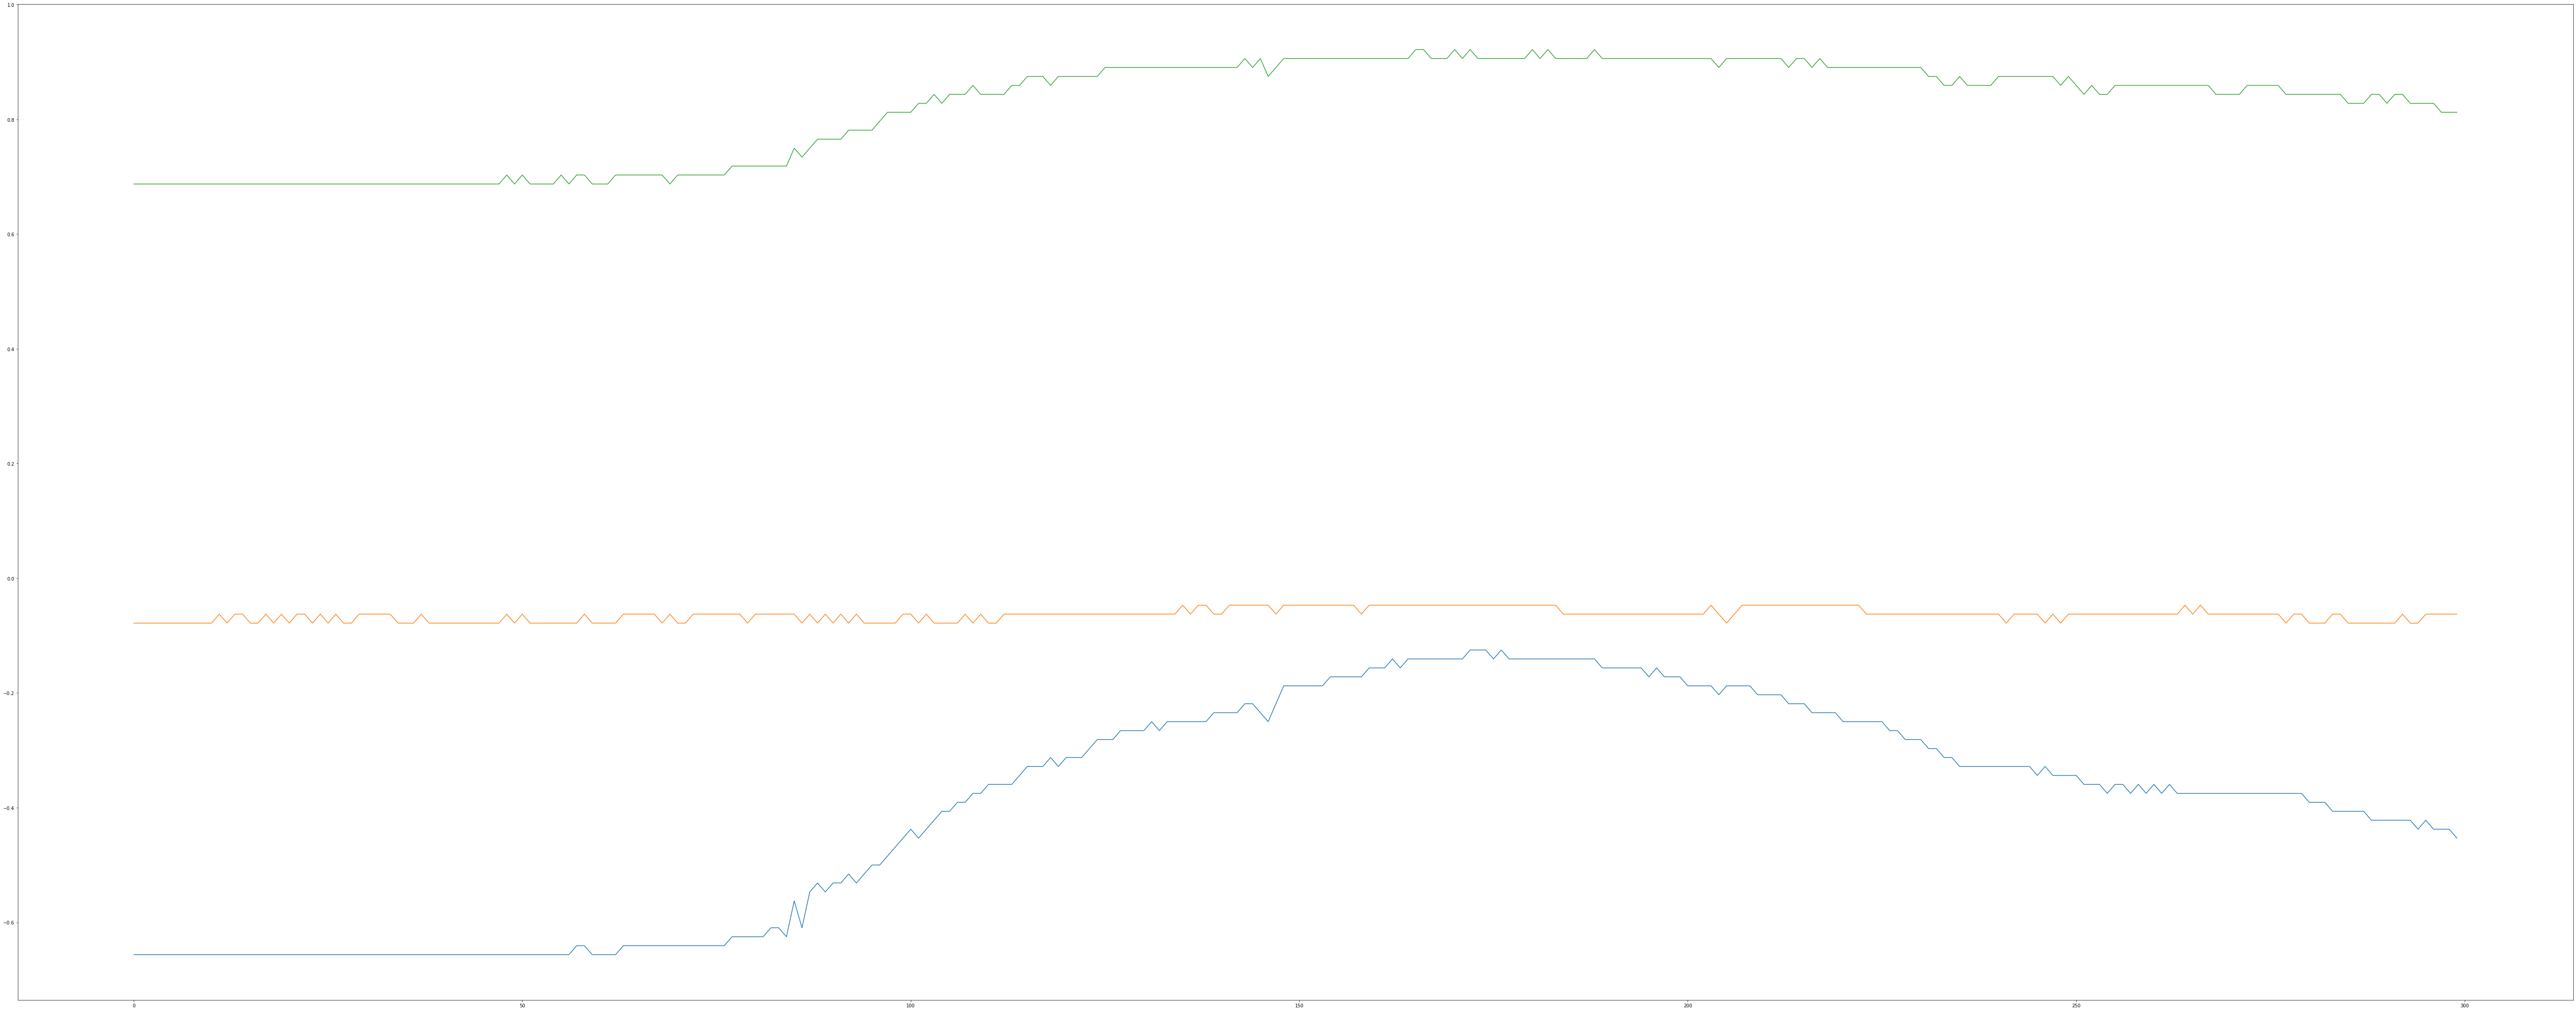

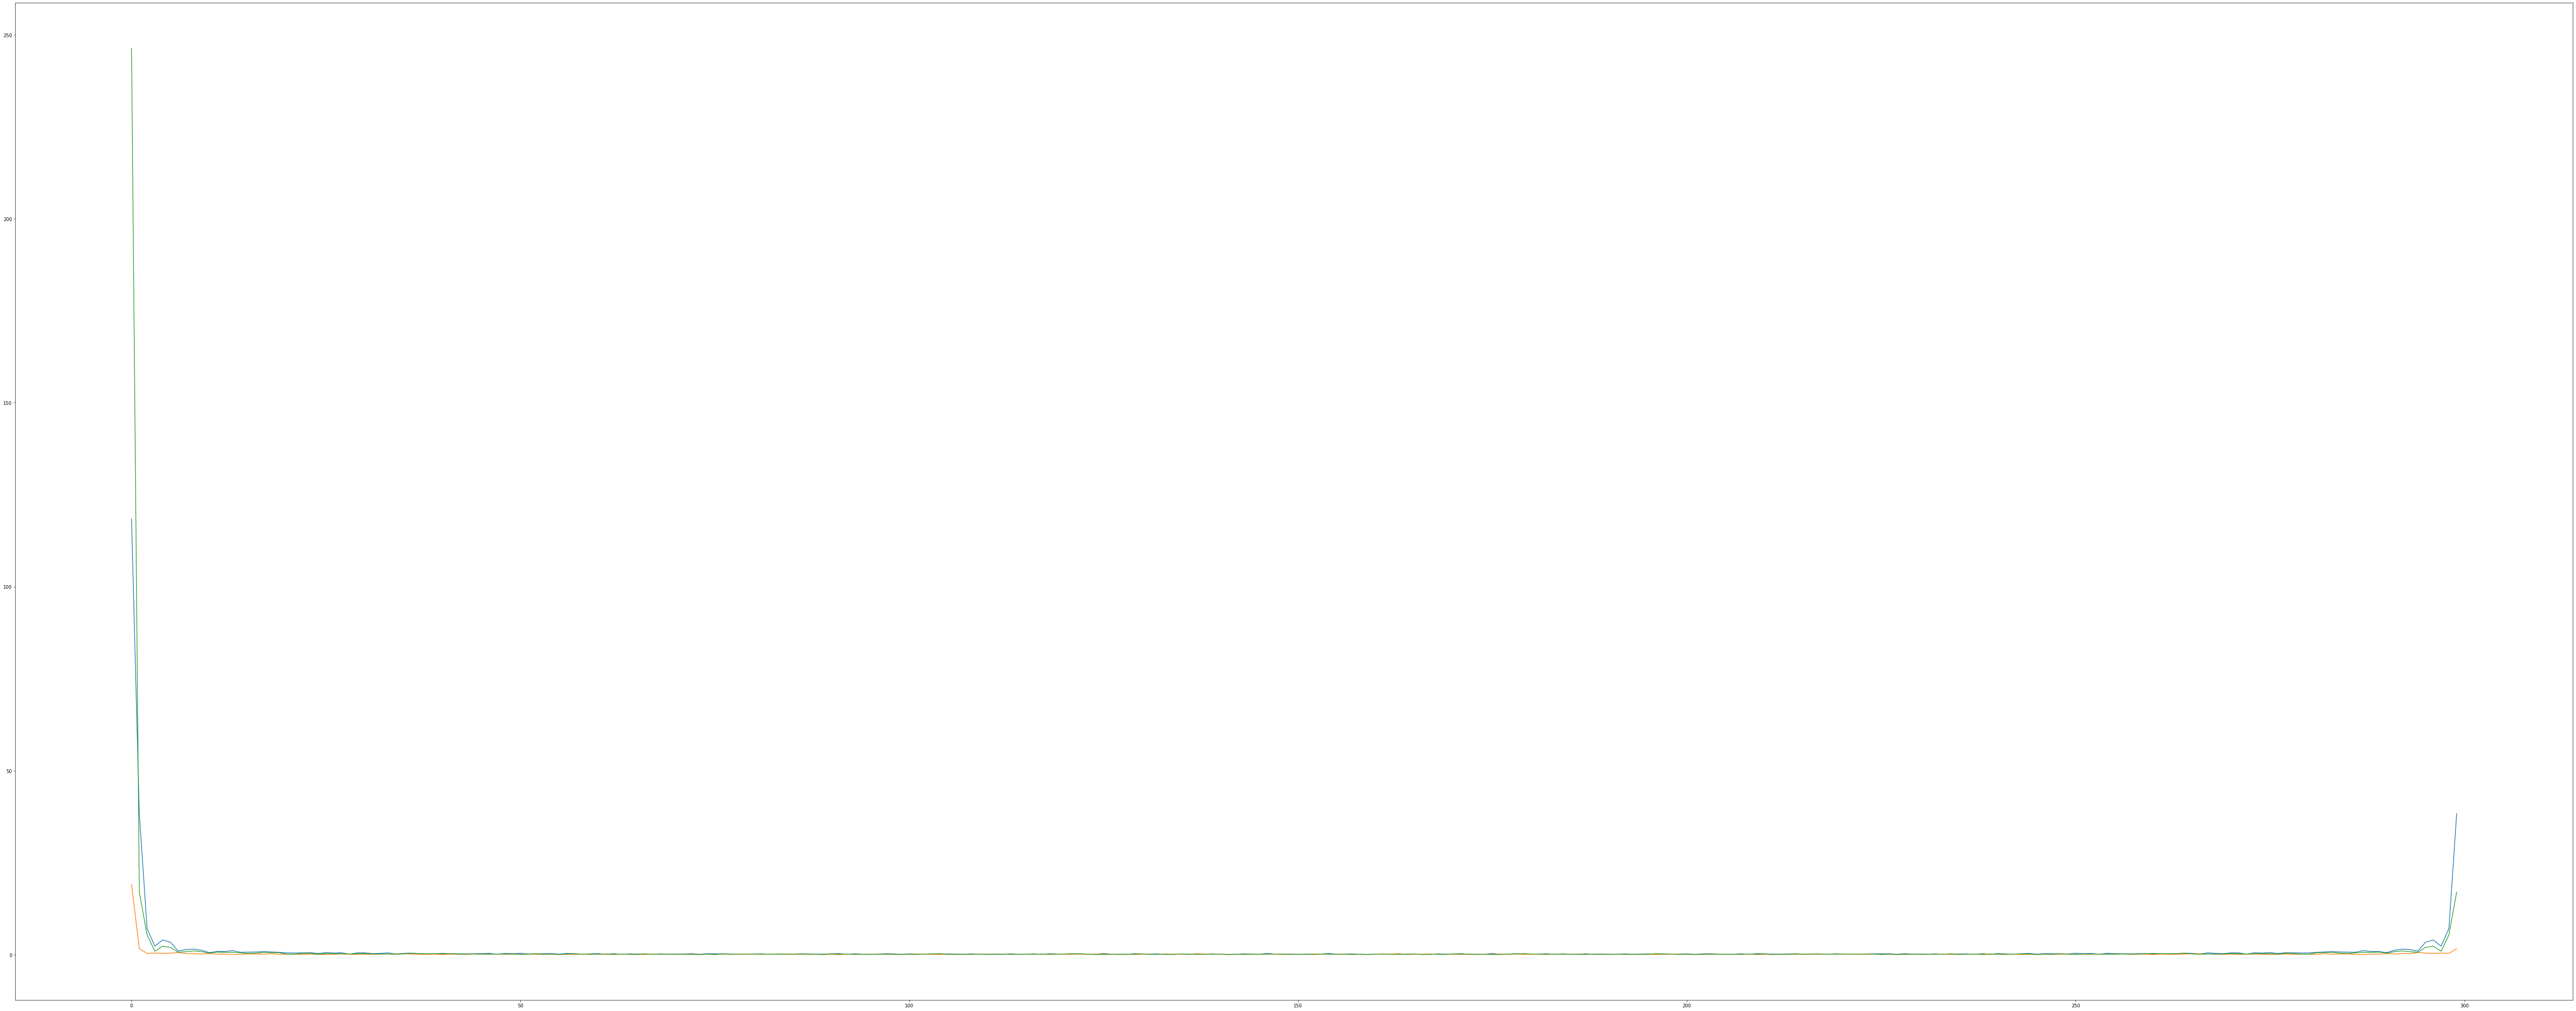

In [142]:
seconds = 3
samples100 = 100*seconds

acw_X_cols = [f"acw_X_{val}" for val in range(0, samples100)]
acw_Y_cols = [f"acw_Y_{val}" for val in range(0, samples100)]
acw_Z_cols = [f"acw_Z_{val}" for val in range(0, samples100)]

act_X_cols = [f"act_X_{val}" for val in range(0, samples100)]
act_Y_cols = [f"act_Y_{val}" for val in range(0, samples100)]
act_Z_cols = [f"act_Z_{val}" for val in range(0, samples100)]

x = df_batched[acw_X_cols].to_numpy()
y = df_batched[acw_Y_cols].to_numpy()
z = df_batched[acw_Z_cols].to_numpy()

plot_acc_data_numpy(x[0,:], y[0,:], z[0,:])

x_fft = fft(x[0,:])
y_fft = fft(y[0,:])
z_fft = fft(z[0,:])



plot_acc_data_numpy(np.abs(x_fft), np.abs(y_fft), np.abs(z_fft))


In [65]:
if type(total_data['acw']) == pd.core.frame.DataFrame:
    print('here')

here


In [67]:
# make a dataframe with the FFT result

In [68]:
df_batched.head()

,acw_X_0,acw_Y_0,acw_Z_0,acw_X_1,acw_Y_1,acw_Z_1,acw_X_2,acw_Y_2,acw_Z_2,acw_X_3,...,act_X_297,act_Y_297,act_Z_297,act_X_298,act_Y_298,act_Z_298,act_X_299,act_Y_299,act_Z_299,action
0,-0.656250,-0.078125,0.687500,-0.656250,-0.078125,0.687500,-0.656250,-0.078125,0.68750,-0.656250,...,-0.750000,0.640625,-0.125000,-0.750000,0.625000,-0.140625,-0.750000,0.625000,-0.140625,1
1,-0.437500,-0.062500,0.812500,-0.453125,-0.062500,0.812500,-0.453125,-0.062500,0.81250,-0.453125,...,-0.703125,0.484375,-0.468750,-0.703125,0.468750,-0.468750,-0.703125,0.468750,-0.453125,1
2,-0.687500,0.015625,0.671875,-0.703125,0.015625,0.671875,-0.687500,0.015625,0.65625,-0.687500,...,-0.703125,0.484375,-0.421875,-0.718750,0.484375,-0.421875,-0.718750,0.453125,-0.437500,1
3,-0.625000,0.000000,0.718750,-0.625000,0.000000,0.718750,-0.640625,0.000000,0.71875,-0.640625,...,-0.687500,0.593750,-0.203125,-0.687500,0.609375,-0.203125,-0.703125,0.609375,-0.187500,1
4,-0.578125,0.046875,0.750000,-0.578125,0.046875,0.750000,-0.578125,0.046875,0.75000,-0.562500,...,-0.296875,0.109375,-0.890625,-0.265625,0.203125,-0.953125,-0.265625,0.109375,-0.921875,1


In [72]:
df_batched.to_numpy().shape

(2796, 33481)

In [86]:
for col in df_batched.columns:
    print(col)

acw_X_0
acw_Y_0
acw_Z_0
acw_X_1
acw_Y_1
acw_Z_1
acw_X_2
acw_Y_2
acw_Z_2
acw_X_3
acw_Y_3
acw_Z_3
acw_X_4
acw_Y_4
acw_Z_4
acw_X_5
acw_Y_5
acw_Z_5
acw_X_6
acw_Y_6
acw_Z_6
acw_X_7
acw_Y_7
acw_Z_7
acw_X_8
acw_Y_8
acw_Z_8
acw_X_9
acw_Y_9
acw_Z_9
acw_X_10
acw_Y_10
acw_Z_10
acw_X_11
acw_Y_11
acw_Z_11
acw_X_12
acw_Y_12
acw_Z_12
acw_X_13
acw_Y_13
acw_Z_13
acw_X_14
acw_Y_14
acw_Z_14
acw_X_15
acw_Y_15
acw_Z_15
acw_X_16
acw_Y_16
acw_Z_16
acw_X_17
acw_Y_17
acw_Z_17
acw_X_18
acw_Y_18
acw_Z_18
acw_X_19
acw_Y_19
acw_Z_19
acw_X_20
acw_Y_20
acw_Z_20
acw_X_21
acw_Y_21
acw_Z_21
acw_X_22
acw_Y_22
acw_Z_22
acw_X_23
acw_Y_23
acw_Z_23
acw_X_24
acw_Y_24
acw_Z_24
acw_X_25
acw_Y_25
acw_Z_25
acw_X_26
acw_Y_26
acw_Z_26
acw_X_27
acw_Y_27
acw_Z_27
acw_X_28
acw_Y_28
acw_Z_28
acw_X_29
acw_Y_29
acw_Z_29
acw_X_30
acw_Y_30
acw_Z_30
acw_X_31
acw_Y_31
acw_Z_31
acw_X_32
acw_Y_32
acw_Z_32
acw_X_33
acw_Y_33
acw_Z_33
acw_X_34
acw_Y_34
acw_Z_34
acw_X_35
acw_Y_35
acw_Z_35
acw_X_36
acw_Y_36
acw_Z_36
acw_X_37
acw_Y_37
acw_Z_37
acw_

dc_sensor_191_5
dc_sensor_192_5
dc_sensor_1_6
dc_sensor_2_6
dc_sensor_3_6
dc_sensor_4_6
dc_sensor_5_6
dc_sensor_6_6
dc_sensor_7_6
dc_sensor_8_6
dc_sensor_9_6
dc_sensor_10_6
dc_sensor_11_6
dc_sensor_12_6
dc_sensor_13_6
dc_sensor_14_6
dc_sensor_15_6
dc_sensor_16_6
dc_sensor_17_6
dc_sensor_18_6
dc_sensor_19_6
dc_sensor_20_6
dc_sensor_21_6
dc_sensor_22_6
dc_sensor_23_6
dc_sensor_24_6
dc_sensor_25_6
dc_sensor_26_6
dc_sensor_27_6
dc_sensor_28_6
dc_sensor_29_6
dc_sensor_30_6
dc_sensor_31_6
dc_sensor_32_6
dc_sensor_33_6
dc_sensor_34_6
dc_sensor_35_6
dc_sensor_36_6
dc_sensor_37_6
dc_sensor_38_6
dc_sensor_39_6
dc_sensor_40_6
dc_sensor_41_6
dc_sensor_42_6
dc_sensor_43_6
dc_sensor_44_6
dc_sensor_45_6
dc_sensor_46_6
dc_sensor_47_6
dc_sensor_48_6
dc_sensor_49_6
dc_sensor_50_6
dc_sensor_51_6
dc_sensor_52_6
dc_sensor_53_6
dc_sensor_54_6
dc_sensor_55_6
dc_sensor_56_6
dc_sensor_57_6
dc_sensor_58_6
dc_sensor_59_6
dc_sensor_60_6
dc_sensor_61_6
dc_sensor_62_6
dc_sensor_63_6
dc_sensor_64_6
dc_sensor_65_6
dc

dc_sensor_82_17
dc_sensor_83_17
dc_sensor_84_17
dc_sensor_85_17
dc_sensor_86_17
dc_sensor_87_17
dc_sensor_88_17
dc_sensor_89_17
dc_sensor_90_17
dc_sensor_91_17
dc_sensor_92_17
dc_sensor_93_17
dc_sensor_94_17
dc_sensor_95_17
dc_sensor_96_17
dc_sensor_97_17
dc_sensor_98_17
dc_sensor_99_17
dc_sensor_100_17
dc_sensor_101_17
dc_sensor_102_17
dc_sensor_103_17
dc_sensor_104_17
dc_sensor_105_17
dc_sensor_106_17
dc_sensor_107_17
dc_sensor_108_17
dc_sensor_109_17
dc_sensor_110_17
dc_sensor_111_17
dc_sensor_112_17
dc_sensor_113_17
dc_sensor_114_17
dc_sensor_115_17
dc_sensor_116_17
dc_sensor_117_17
dc_sensor_118_17
dc_sensor_119_17
dc_sensor_120_17
dc_sensor_121_17
dc_sensor_122_17
dc_sensor_123_17
dc_sensor_124_17
dc_sensor_125_17
dc_sensor_126_17
dc_sensor_127_17
dc_sensor_128_17
dc_sensor_129_17
dc_sensor_130_17
dc_sensor_131_17
dc_sensor_132_17
dc_sensor_133_17
dc_sensor_134_17
dc_sensor_135_17
dc_sensor_136_17
dc_sensor_137_17
dc_sensor_138_17
dc_sensor_139_17
dc_sensor_140_17
dc_sensor_141_1

dc_sensor_183_28
dc_sensor_184_28
dc_sensor_185_28
dc_sensor_186_28
dc_sensor_187_28
dc_sensor_188_28
dc_sensor_189_28
dc_sensor_190_28
dc_sensor_191_28
dc_sensor_192_28
dc_sensor_1_29
dc_sensor_2_29
dc_sensor_3_29
dc_sensor_4_29
dc_sensor_5_29
dc_sensor_6_29
dc_sensor_7_29
dc_sensor_8_29
dc_sensor_9_29
dc_sensor_10_29
dc_sensor_11_29
dc_sensor_12_29
dc_sensor_13_29
dc_sensor_14_29
dc_sensor_15_29
dc_sensor_16_29
dc_sensor_17_29
dc_sensor_18_29
dc_sensor_19_29
dc_sensor_20_29
dc_sensor_21_29
dc_sensor_22_29
dc_sensor_23_29
dc_sensor_24_29
dc_sensor_25_29
dc_sensor_26_29
dc_sensor_27_29
dc_sensor_28_29
dc_sensor_29_29
dc_sensor_30_29
dc_sensor_31_29
dc_sensor_32_29
dc_sensor_33_29
dc_sensor_34_29
dc_sensor_35_29
dc_sensor_36_29
dc_sensor_37_29
dc_sensor_38_29
dc_sensor_39_29
dc_sensor_40_29
dc_sensor_41_29
dc_sensor_42_29
dc_sensor_43_29
dc_sensor_44_29
dc_sensor_45_29
dc_sensor_46_29
dc_sensor_47_29
dc_sensor_48_29
dc_sensor_49_29
dc_sensor_50_29
dc_sensor_51_29
dc_sensor_52_29
dc_sens

dc_sensor_65_40
dc_sensor_66_40
dc_sensor_67_40
dc_sensor_68_40
dc_sensor_69_40
dc_sensor_70_40
dc_sensor_71_40
dc_sensor_72_40
dc_sensor_73_40
dc_sensor_74_40
dc_sensor_75_40
dc_sensor_76_40
dc_sensor_77_40
dc_sensor_78_40
dc_sensor_79_40
dc_sensor_80_40
dc_sensor_81_40
dc_sensor_82_40
dc_sensor_83_40
dc_sensor_84_40
dc_sensor_85_40
dc_sensor_86_40
dc_sensor_87_40
dc_sensor_88_40
dc_sensor_89_40
dc_sensor_90_40
dc_sensor_91_40
dc_sensor_92_40
dc_sensor_93_40
dc_sensor_94_40
dc_sensor_95_40
dc_sensor_96_40
dc_sensor_97_40
dc_sensor_98_40
dc_sensor_99_40
dc_sensor_100_40
dc_sensor_101_40
dc_sensor_102_40
dc_sensor_103_40
dc_sensor_104_40
dc_sensor_105_40
dc_sensor_106_40
dc_sensor_107_40
dc_sensor_108_40
dc_sensor_109_40
dc_sensor_110_40
dc_sensor_111_40
dc_sensor_112_40
dc_sensor_113_40
dc_sensor_114_40
dc_sensor_115_40
dc_sensor_116_40
dc_sensor_117_40
dc_sensor_118_40
dc_sensor_119_40
dc_sensor_120_40
dc_sensor_121_40
dc_sensor_122_40
dc_sensor_123_40
dc_sensor_124_40
dc_sensor_125_4

pm_sensor_399_2
pm_sensor_400_2
pm_sensor_401_2
pm_sensor_402_2
pm_sensor_403_2
pm_sensor_404_2
pm_sensor_405_2
pm_sensor_406_2
pm_sensor_407_2
pm_sensor_408_2
pm_sensor_409_2
pm_sensor_410_2
pm_sensor_411_2
pm_sensor_412_2
pm_sensor_413_2
pm_sensor_414_2
pm_sensor_415_2
pm_sensor_416_2
pm_sensor_417_2
pm_sensor_418_2
pm_sensor_419_2
pm_sensor_420_2
pm_sensor_421_2
pm_sensor_422_2
pm_sensor_423_2
pm_sensor_424_2
pm_sensor_425_2
pm_sensor_426_2
pm_sensor_427_2
pm_sensor_428_2
pm_sensor_429_2
pm_sensor_430_2
pm_sensor_431_2
pm_sensor_432_2
pm_sensor_433_2
pm_sensor_434_2
pm_sensor_435_2
pm_sensor_436_2
pm_sensor_437_2
pm_sensor_438_2
pm_sensor_439_2
pm_sensor_440_2
pm_sensor_441_2
pm_sensor_442_2
pm_sensor_443_2
pm_sensor_444_2
pm_sensor_445_2
pm_sensor_446_2
pm_sensor_447_2
pm_sensor_448_2
pm_sensor_449_2
pm_sensor_450_2
pm_sensor_451_2
pm_sensor_452_2
pm_sensor_453_2
pm_sensor_454_2
pm_sensor_455_2
pm_sensor_456_2
pm_sensor_457_2
pm_sensor_458_2
pm_sensor_459_2
pm_sensor_460_2
pm_senso

pm_sensor_235_7
pm_sensor_236_7
pm_sensor_237_7
pm_sensor_238_7
pm_sensor_239_7
pm_sensor_240_7
pm_sensor_241_7
pm_sensor_242_7
pm_sensor_243_7
pm_sensor_244_7
pm_sensor_245_7
pm_sensor_246_7
pm_sensor_247_7
pm_sensor_248_7
pm_sensor_249_7
pm_sensor_250_7
pm_sensor_251_7
pm_sensor_252_7
pm_sensor_253_7
pm_sensor_254_7
pm_sensor_255_7
pm_sensor_256_7
pm_sensor_257_7
pm_sensor_258_7
pm_sensor_259_7
pm_sensor_260_7
pm_sensor_261_7
pm_sensor_262_7
pm_sensor_263_7
pm_sensor_264_7
pm_sensor_265_7
pm_sensor_266_7
pm_sensor_267_7
pm_sensor_268_7
pm_sensor_269_7
pm_sensor_270_7
pm_sensor_271_7
pm_sensor_272_7
pm_sensor_273_7
pm_sensor_274_7
pm_sensor_275_7
pm_sensor_276_7
pm_sensor_277_7
pm_sensor_278_7
pm_sensor_279_7
pm_sensor_280_7
pm_sensor_281_7
pm_sensor_282_7
pm_sensor_283_7
pm_sensor_284_7
pm_sensor_285_7
pm_sensor_286_7
pm_sensor_287_7
pm_sensor_288_7
pm_sensor_289_7
pm_sensor_290_7
pm_sensor_291_7
pm_sensor_292_7
pm_sensor_293_7
pm_sensor_294_7
pm_sensor_295_7
pm_sensor_296_7
pm_senso

pm_sensor_401_11
pm_sensor_402_11
pm_sensor_403_11
pm_sensor_404_11
pm_sensor_405_11
pm_sensor_406_11
pm_sensor_407_11
pm_sensor_408_11
pm_sensor_409_11
pm_sensor_410_11
pm_sensor_411_11
pm_sensor_412_11
pm_sensor_413_11
pm_sensor_414_11
pm_sensor_415_11
pm_sensor_416_11
pm_sensor_417_11
pm_sensor_418_11
pm_sensor_419_11
pm_sensor_420_11
pm_sensor_421_11
pm_sensor_422_11
pm_sensor_423_11
pm_sensor_424_11
pm_sensor_425_11
pm_sensor_426_11
pm_sensor_427_11
pm_sensor_428_11
pm_sensor_429_11
pm_sensor_430_11
pm_sensor_431_11
pm_sensor_432_11
pm_sensor_433_11
pm_sensor_434_11
pm_sensor_435_11
pm_sensor_436_11
pm_sensor_437_11
pm_sensor_438_11
pm_sensor_439_11
pm_sensor_440_11
pm_sensor_441_11
pm_sensor_442_11
pm_sensor_443_11
pm_sensor_444_11
pm_sensor_445_11
pm_sensor_446_11
pm_sensor_447_11
pm_sensor_448_11
pm_sensor_449_11
pm_sensor_450_11
pm_sensor_451_11
pm_sensor_452_11
pm_sensor_453_11
pm_sensor_454_11
pm_sensor_455_11
pm_sensor_456_11
pm_sensor_457_11
pm_sensor_458_11
pm_sensor_459_

pm_sensor_145_16
pm_sensor_146_16
pm_sensor_147_16
pm_sensor_148_16
pm_sensor_149_16
pm_sensor_150_16
pm_sensor_151_16
pm_sensor_152_16
pm_sensor_153_16
pm_sensor_154_16
pm_sensor_155_16
pm_sensor_156_16
pm_sensor_157_16
pm_sensor_158_16
pm_sensor_159_16
pm_sensor_160_16
pm_sensor_161_16
pm_sensor_162_16
pm_sensor_163_16
pm_sensor_164_16
pm_sensor_165_16
pm_sensor_166_16
pm_sensor_167_16
pm_sensor_168_16
pm_sensor_169_16
pm_sensor_170_16
pm_sensor_171_16
pm_sensor_172_16
pm_sensor_173_16
pm_sensor_174_16
pm_sensor_175_16
pm_sensor_176_16
pm_sensor_177_16
pm_sensor_178_16
pm_sensor_179_16
pm_sensor_180_16
pm_sensor_181_16
pm_sensor_182_16
pm_sensor_183_16
pm_sensor_184_16
pm_sensor_185_16
pm_sensor_186_16
pm_sensor_187_16
pm_sensor_188_16
pm_sensor_189_16
pm_sensor_190_16
pm_sensor_191_16
pm_sensor_192_16
pm_sensor_193_16
pm_sensor_194_16
pm_sensor_195_16
pm_sensor_196_16
pm_sensor_197_16
pm_sensor_198_16
pm_sensor_199_16
pm_sensor_200_16
pm_sensor_201_16
pm_sensor_202_16
pm_sensor_203_

pm_sensor_433_20
pm_sensor_434_20
pm_sensor_435_20
pm_sensor_436_20
pm_sensor_437_20
pm_sensor_438_20
pm_sensor_439_20
pm_sensor_440_20
pm_sensor_441_20
pm_sensor_442_20
pm_sensor_443_20
pm_sensor_444_20
pm_sensor_445_20
pm_sensor_446_20
pm_sensor_447_20
pm_sensor_448_20
pm_sensor_449_20
pm_sensor_450_20
pm_sensor_451_20
pm_sensor_452_20
pm_sensor_453_20
pm_sensor_454_20
pm_sensor_455_20
pm_sensor_456_20
pm_sensor_457_20
pm_sensor_458_20
pm_sensor_459_20
pm_sensor_460_20
pm_sensor_461_20
pm_sensor_462_20
pm_sensor_463_20
pm_sensor_464_20
pm_sensor_465_20
pm_sensor_466_20
pm_sensor_467_20
pm_sensor_468_20
pm_sensor_469_20
pm_sensor_470_20
pm_sensor_471_20
pm_sensor_472_20
pm_sensor_473_20
pm_sensor_474_20
pm_sensor_475_20
pm_sensor_476_20
pm_sensor_477_20
pm_sensor_478_20
pm_sensor_479_20
pm_sensor_480_20
pm_sensor_481_20
pm_sensor_482_20
pm_sensor_483_20
pm_sensor_484_20
pm_sensor_485_20
pm_sensor_486_20
pm_sensor_487_20
pm_sensor_488_20
pm_sensor_489_20
pm_sensor_490_20
pm_sensor_491_

pm_sensor_325_25
pm_sensor_326_25
pm_sensor_327_25
pm_sensor_328_25
pm_sensor_329_25
pm_sensor_330_25
pm_sensor_331_25
pm_sensor_332_25
pm_sensor_333_25
pm_sensor_334_25
pm_sensor_335_25
pm_sensor_336_25
pm_sensor_337_25
pm_sensor_338_25
pm_sensor_339_25
pm_sensor_340_25
pm_sensor_341_25
pm_sensor_342_25
pm_sensor_343_25
pm_sensor_344_25
pm_sensor_345_25
pm_sensor_346_25
pm_sensor_347_25
pm_sensor_348_25
pm_sensor_349_25
pm_sensor_350_25
pm_sensor_351_25
pm_sensor_352_25
pm_sensor_353_25
pm_sensor_354_25
pm_sensor_355_25
pm_sensor_356_25
pm_sensor_357_25
pm_sensor_358_25
pm_sensor_359_25
pm_sensor_360_25
pm_sensor_361_25
pm_sensor_362_25
pm_sensor_363_25
pm_sensor_364_25
pm_sensor_365_25
pm_sensor_366_25
pm_sensor_367_25
pm_sensor_368_25
pm_sensor_369_25
pm_sensor_370_25
pm_sensor_371_25
pm_sensor_372_25
pm_sensor_373_25
pm_sensor_374_25
pm_sensor_375_25
pm_sensor_376_25
pm_sensor_377_25
pm_sensor_378_25
pm_sensor_379_25
pm_sensor_380_25
pm_sensor_381_25
pm_sensor_382_25
pm_sensor_383_

pm_sensor_406_29
pm_sensor_407_29
pm_sensor_408_29
pm_sensor_409_29
pm_sensor_410_29
pm_sensor_411_29
pm_sensor_412_29
pm_sensor_413_29
pm_sensor_414_29
pm_sensor_415_29
pm_sensor_416_29
pm_sensor_417_29
pm_sensor_418_29
pm_sensor_419_29
pm_sensor_420_29
pm_sensor_421_29
pm_sensor_422_29
pm_sensor_423_29
pm_sensor_424_29
pm_sensor_425_29
pm_sensor_426_29
pm_sensor_427_29
pm_sensor_428_29
pm_sensor_429_29
pm_sensor_430_29
pm_sensor_431_29
pm_sensor_432_29
pm_sensor_433_29
pm_sensor_434_29
pm_sensor_435_29
pm_sensor_436_29
pm_sensor_437_29
pm_sensor_438_29
pm_sensor_439_29
pm_sensor_440_29
pm_sensor_441_29
pm_sensor_442_29
pm_sensor_443_29
pm_sensor_444_29
pm_sensor_445_29
pm_sensor_446_29
pm_sensor_447_29
pm_sensor_448_29
pm_sensor_449_29
pm_sensor_450_29
pm_sensor_451_29
pm_sensor_452_29
pm_sensor_453_29
pm_sensor_454_29
pm_sensor_455_29
pm_sensor_456_29
pm_sensor_457_29
pm_sensor_458_29
pm_sensor_459_29
pm_sensor_460_29
pm_sensor_461_29
pm_sensor_462_29
pm_sensor_463_29
pm_sensor_464_

pm_sensor_197_34
pm_sensor_198_34
pm_sensor_199_34
pm_sensor_200_34
pm_sensor_201_34
pm_sensor_202_34
pm_sensor_203_34
pm_sensor_204_34
pm_sensor_205_34
pm_sensor_206_34
pm_sensor_207_34
pm_sensor_208_34
pm_sensor_209_34
pm_sensor_210_34
pm_sensor_211_34
pm_sensor_212_34
pm_sensor_213_34
pm_sensor_214_34
pm_sensor_215_34
pm_sensor_216_34
pm_sensor_217_34
pm_sensor_218_34
pm_sensor_219_34
pm_sensor_220_34
pm_sensor_221_34
pm_sensor_222_34
pm_sensor_223_34
pm_sensor_224_34
pm_sensor_225_34
pm_sensor_226_34
pm_sensor_227_34
pm_sensor_228_34
pm_sensor_229_34
pm_sensor_230_34
pm_sensor_231_34
pm_sensor_232_34
pm_sensor_233_34
pm_sensor_234_34
pm_sensor_235_34
pm_sensor_236_34
pm_sensor_237_34
pm_sensor_238_34
pm_sensor_239_34
pm_sensor_240_34
pm_sensor_241_34
pm_sensor_242_34
pm_sensor_243_34
pm_sensor_244_34
pm_sensor_245_34
pm_sensor_246_34
pm_sensor_247_34
pm_sensor_248_34
pm_sensor_249_34
pm_sensor_250_34
pm_sensor_251_34
pm_sensor_252_34
pm_sensor_253_34
pm_sensor_254_34
pm_sensor_255_

pm_sensor_478_38
pm_sensor_479_38
pm_sensor_480_38
pm_sensor_481_38
pm_sensor_482_38
pm_sensor_483_38
pm_sensor_484_38
pm_sensor_485_38
pm_sensor_486_38
pm_sensor_487_38
pm_sensor_488_38
pm_sensor_489_38
pm_sensor_490_38
pm_sensor_491_38
pm_sensor_492_38
pm_sensor_493_38
pm_sensor_494_38
pm_sensor_495_38
pm_sensor_496_38
pm_sensor_497_38
pm_sensor_498_38
pm_sensor_499_38
pm_sensor_500_38
pm_sensor_501_38
pm_sensor_502_38
pm_sensor_503_38
pm_sensor_504_38
pm_sensor_505_38
pm_sensor_506_38
pm_sensor_507_38
pm_sensor_508_38
pm_sensor_509_38
pm_sensor_510_38
pm_sensor_511_38
pm_sensor_512_38
pm_sensor_1_39
pm_sensor_2_39
pm_sensor_3_39
pm_sensor_4_39
pm_sensor_5_39
pm_sensor_6_39
pm_sensor_7_39
pm_sensor_8_39
pm_sensor_9_39
pm_sensor_10_39
pm_sensor_11_39
pm_sensor_12_39
pm_sensor_13_39
pm_sensor_14_39
pm_sensor_15_39
pm_sensor_16_39
pm_sensor_17_39
pm_sensor_18_39
pm_sensor_19_39
pm_sensor_20_39
pm_sensor_21_39
pm_sensor_22_39
pm_sensor_23_39
pm_sensor_24_39
pm_sensor_25_39
pm_sensor_26_3

pm_sensor_210_43
pm_sensor_211_43
pm_sensor_212_43
pm_sensor_213_43
pm_sensor_214_43
pm_sensor_215_43
pm_sensor_216_43
pm_sensor_217_43
pm_sensor_218_43
pm_sensor_219_43
pm_sensor_220_43
pm_sensor_221_43
pm_sensor_222_43
pm_sensor_223_43
pm_sensor_224_43
pm_sensor_225_43
pm_sensor_226_43
pm_sensor_227_43
pm_sensor_228_43
pm_sensor_229_43
pm_sensor_230_43
pm_sensor_231_43
pm_sensor_232_43
pm_sensor_233_43
pm_sensor_234_43
pm_sensor_235_43
pm_sensor_236_43
pm_sensor_237_43
pm_sensor_238_43
pm_sensor_239_43
pm_sensor_240_43
pm_sensor_241_43
pm_sensor_242_43
pm_sensor_243_43
pm_sensor_244_43
pm_sensor_245_43
pm_sensor_246_43
pm_sensor_247_43
pm_sensor_248_43
pm_sensor_249_43
pm_sensor_250_43
pm_sensor_251_43
pm_sensor_252_43
pm_sensor_253_43
pm_sensor_254_43
pm_sensor_255_43
pm_sensor_256_43
pm_sensor_257_43
pm_sensor_258_43
pm_sensor_259_43
pm_sensor_260_43
pm_sensor_261_43
pm_sensor_262_43
pm_sensor_263_43
pm_sensor_264_43
pm_sensor_265_43
pm_sensor_266_43
pm_sensor_267_43
pm_sensor_268_

In [94]:
samples15 = 15*seconds
dc_cols = [f"dc_sensor_{val}_{i}" for val in range(1, 193) for i in range(0,samples15)]
pm_cols = [f"pm_sensor_{val}_{i}" for val in range(1, 513) for i in range(0,samples15)]

In [143]:
fft_data_acw = np.zeros(900*2796).reshape(2796, 900)
for index, row in df_batched.iterrows():
    X = row[acw_X_cols].to_numpy()
    X_fft = fft(X)
    X_fft = np.abs(X_fft)
    
    Y = row[acw_Y_cols].to_numpy()
    Y_fft = fft(Y)
    Y_fft = np.abs(Y_fft)
    
    Z = row[acw_Z_cols].to_numpy()
    Z_fft = fft(Z)
    Z_fft = np.abs(Z_fft)
    
    fft_all = np.concatenate([X_fft, Y_fft, Z_fft])
    
    fft_data_acw[index] = fft_all

In [144]:
fft_data_act = np.zeros(900*2796).reshape(2796, 900)
for index, row in df_batched.iterrows():
    X = row[act_X_cols].to_numpy()
    X_fft = fft(X)
    X_fft = np.abs(X_fft)
    
    Y = row[act_Y_cols].to_numpy()
    Y_fft = fft(Y)
    Y_fft = np.abs(Y_fft)
    
    Z = row[act_Z_cols].to_numpy()
    Z_fft = fft(Z)
    Z_fft = np.abs(Z_fft)
    
    fft_all = np.concatenate([X_fft, Y_fft, Z_fft])
    
    fft_data_act[index] = fft_all

In [120]:
# we have 300 different x,y,z's for each acc

##wrist data
acw_X_cols_batched = []
for j in range(0, samples100):
    acw_X_cols_batched += [f"acw_{val}_{j}" for val in XYZ]
X_acw_batched = df_batched[acw_X_cols_batched].to_numpy()

# thigh data
XYZ = ["X", "Y", "Z"]
act_X_cols_batched = []
for j in range(0, samples100):
    act_X_cols_batched += [f"act_{val}_{j}" for val in XYZ]
X_act_batched = df_batched[act_X_cols_batched].to_numpy()

# Depth Camera data
dc_X_cols_batched = []
for j in range(0, samples15):
    dc_X_cols_batched += [f"dc_{val}_{j}" for val in dc_X_cols]
X_dc_batched = df_batched[dc_X_cols_batched].to_numpy()
    
# Pressure Mat data
pm_X_cols_batched = []
for j in range(0, samples15):
    pm_X_cols_batched += [f"pm_{val}_{j}" for val in pm_X_cols]
X_pm_batched = df_batched[pm_X_cols_batched].to_numpy()
len(pm_X_cols_batched)

23040

In [158]:
df_y = pd.get_dummies(df_batched.action, prefix='action_ohe')
y = df_y.to_numpy()
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [159]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
fft_data_act_train, fft_data_act_test, \
fft_data_acw_train, fft_data_acw_test, \
X_dc_batched_train, X_dc_batched_test, \
X_pm_batched_train, X_pm_batched_test, \
y_train, y_test = \
train_test_split(fft_data_act, fft_data_acw, X_dc_batched, X_pm_batched, y, 
                 test_size=0.2, shuffle=True)

print(fft_data_act_train.shape)
print(fft_data_act_test.shape)
print(fft_data_acw_train.shape)
print(fft_data_acw_test.shape)
print(X_dc_batched_train.shape)
print(X_dc_batched_test.shape)
print(X_pm_batched_train.shape)
print(X_pm_batched_test.shape)
print(y_train.shape)
print(y_test.shape)

(2236, 900)
(560, 900)
(2236, 900)
(560, 900)
(2236, 8640)
(560, 8640)
(2236, 23040)
(560, 23040)
(2236, 8)
(560, 8)


In [160]:
X_pm_batched_train = X_pm_batched_train.reshape(X_pm_batched_train.shape[0],45,32,16)
X_pm_batched_test = X_pm_batched_test.reshape(X_pm_batched_test.shape[0],45,32,16)

print(X_pm_batched_train.shape)
X_dc_batched_train = X_dc_batched_train.reshape(X_dc_batched_train.shape[0],45,12,16)
X_dc_batched_test = X_dc_batched_test.reshape(X_dc_batched_test.shape[0],45,12,16)

(2236, 45, 32, 16)


In [161]:

def get_multi_modal_model():
    # https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
    input_thigh = Input(shape=(fft_data_act_train.shape[1],))
    input_wrist = Input(shape=(fft_data_acw_train.shape[1],))
    input_dc = Input(shape=(X_dc_batched_train.shape[1],
                            X_dc_batched_train.shape[2],
                            X_dc_batched_train.shape[3],))
    input_pm = Input(shape=(X_pm_batched_train.shape[1],
                            X_pm_batched_train.shape[2],
                            X_pm_batched_train.shape[3],))

    # Build some layers for the thigh
    thigh = Dense(1024, activation="sigmoid")(input_thigh)
    thigh = Dense(512, activation="sigmoid")(thigh)
    thigh = Dropout(0.1)(thigh)
    thigh = Dense(256)(thigh)
    thigh = Dense(128)(thigh)
    thigh = Dense(128)(thigh)
    thigh = Model(inputs=input_thigh, outputs=thigh)

    # Build some layers for the wrist
    wrist = Dense(1024, activation="sigmoid")(input_wrist)
    wrist = Dense(512, activation="sigmoid")(wrist)
    wrist = Dropout(0.1)(wrist)
    wrist = Dense(256)(wrist)
    wrist = Dense(128)(wrist)
    wrist = Dense(128)(wrist)
    wrist = Model(inputs=input_wrist, outputs=wrist)

    # Build some layers for the depth camera
    # but this time we will use conv2D
    filt_layers = [64, 32, 16]
    dc_tens = Conv2D(filters=filt_layers[0], 
                                kernel_size=(3,3), 
                                padding='same', 
                                activation='relu',
                                data_format="channels_first",
                                input_shape=(X_dc_batched_train.shape[1],
                                             X_dc_batched_train.shape[2],
                                             X_dc_batched_train.shape[3]))(input_dc)
    dc_tens = Dropout(0.1) (dc_tens)
    dc_tens = Conv2D(filters=filt_layers[1], 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu',
                            data_format="channels_first")(dc_tens)
    dc_tens = Dropout(0.1) (dc_tens)

    dc_tens = Conv2D(filters=filt_layers[2], 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu',
                            data_format="channels_first")(dc_tens)
    dc_tens = MaxPooling2D(pool_size=(2, 2), data_format="channels_first")(dc_tens)
    dc_tens = Dropout(0.1) (dc_tens)
    dc_tens = Flatten()(dc_tens)
    dc_tens = Dense(512)(dc_tens)
    dc_tens = Model(inputs=input_dc, outputs=dc_tens)


    # Build some layers for the pressure mat
    pm_tens = Conv2D(filters=filt_layers[0], 
                                kernel_size=(3,3), 
                                padding='same', 
                                activation='relu',
                                data_format="channels_first",
                                input_shape=(X_pm_batched_train.shape[1],
                                             X_pm_batched_train.shape[2],
                                             X_pm_batched_train.shape[3]))(input_pm)
    pm_tens = Dropout(0.1) (pm_tens)
    pm_tens = Conv2D(filters=filt_layers[1], 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu',
                            data_format="channels_first")(pm_tens)
    pm_tens = Dropout(0.1) (pm_tens)

    pm_tens = Conv2D(filters=filt_layers[2], 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu',
                            data_format="channels_first")(pm_tens)
    pm_tens = MaxPooling2D(pool_size=(2, 2), data_format="channels_first")(pm_tens)
    pm_tens = Dropout(0.1) (pm_tens)
    pm_tens = Flatten()(pm_tens)
    pm_tens = Dense(512)(pm_tens)
    pm_tens = Model(inputs=input_pm, outputs=pm_tens)


    combined = concatenate([thigh.output, wrist.output, dc_tens.output, pm_tens.output])

    # Now lets run some more dense layers
    last = Dense(128, activation="tanh")(combined)
    last = Dense(64, activation="tanh")(last)
    prediction = Dense(units=8, activation='softmax')(last)

    model = Model(inputs=[thigh.input, wrist.input, dc_tens.input, pm_tens.input], outputs=prediction)
    return model



In [162]:
from tensorflow.keras.optimizers import Adam
model = get_multi_modal_model()
model.compile(optimizer=Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 45, 12, 16)] 0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 45, 32, 16)] 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 64, 12, 16)   25984       input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 32, 16)   25984       input_24[0][0]                   
___________________________________________________________________________________________

In [163]:
print(y_test)

[[0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [164]:
%%time
history = model.fit(x=[fft_data_act_train, fft_data_acw_train, X_dc_batched_train, X_pm_batched_train],
                    y=y_train, 
                    validation_data=(
                        [fft_data_act_test,
                         fft_data_acw_test,X_dc_batched_test, X_pm_batched_test], y_test),
                    epochs=900,  batch_size=10, verbose=False)

Wall time: 1h 52min 52s


In [176]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12.8,4.8))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
def plot_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12.8,4.8))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.show()

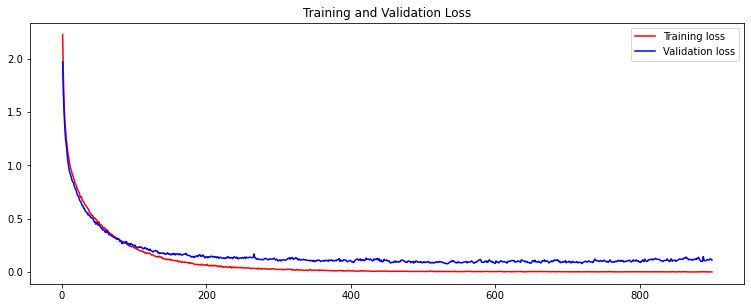

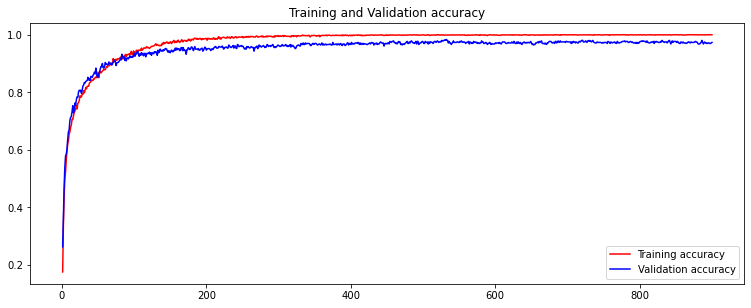

Train: 100.0
Validation: 97.32142857142857


In [181]:

plot_history(history)
plot_acc(history)

yhat = model.predict([fft_data_act_train, fft_data_acw_train, X_dc_batched_train, X_pm_batched_train])
yhat = np.argmax(yhat, axis=1)
y_train_actual = np.argmax(y_train, axis=1)
print('Train:', accuracy_score(y_train_actual, yhat)*100)

yhat = model.predict([fft_data_act_test,
                         fft_data_acw_test,X_dc_batched_test, X_pm_batched_test])
yhat = np.argmax(yhat, axis=1)
y_test_actual = np.argmax(y_test, axis=1)
print('Validation:', accuracy_score(y_test_actual, yhat)*100)

In [200]:
len(df_batch_saved_off)

209

In [201]:
fft_data_act_unseen = np.zeros(900*209).reshape(209, 900)
for index, row in df_batch_saved_off.iterrows():
    X = row[act_X_cols].to_numpy()
    X_fft = fft(X)
    X_fft = np.abs(X_fft)
    
    Y = row[act_Y_cols].to_numpy()
    Y_fft = fft(Y)
    Y_fft = np.abs(Y_fft)
    
    Z = row[act_Z_cols].to_numpy()
    Z_fft = fft(Z)
    Z_fft = np.abs(Z_fft)
    
    fft_all = np.concatenate([X_fft, Y_fft, Z_fft])
    
    fft_data_act_unseen[index] = fft_all
    
fft_data_acw_unseen = np.zeros(900*209).reshape(209, 900)
for index, row in df_batch_saved_off.iterrows():
    X = row[acw_X_cols].to_numpy()
    X_fft = fft(X)
    X_fft = np.abs(X_fft)
    
    Y = row[acw_Y_cols].to_numpy()
    Y_fft = fft(Y)
    Y_fft = np.abs(Y_fft)
    
    Z = row[acw_Z_cols].to_numpy()
    Z_fft = fft(Z)
    Z_fft = np.abs(Z_fft)
    
    fft_all = np.concatenate([X_fft, Y_fft, Z_fft])
    
    fft_data_acw_unseen[index] = fft_all

In [202]:

X_dc_batched_unseen = df_batch_saved_off[dc_X_cols_batched].to_numpy()
X_pm_batched_unseen = df_batch_saved_off[pm_X_cols_batched].to_numpy()
X_pm_batched_unseen = X_pm_batched_unseen.reshape(X_pm_batched_unseen.shape[0],45,32,16)
X_dc_batched_unseen = X_dc_batched_unseen.reshape(X_dc_batched_unseen.shape[0],45,12,16)


In [203]:
df_y_unseen = pd.get_dummies(df_batch_saved_off.action, prefix='action_ohe')
y_unseen = df_y_unseen.to_numpy()
y_unseen

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [204]:
print(fft_data_act_unseen.shape)
print(fft_data_acw_unseen.shape)
print(X_dc_batched_unseen.shape)
df_batch_saved_off[dc_X_cols_batched].to_numpy().shape

(209, 900)
(209, 900)
(209, 45, 12, 16)


(209, 8640)

In [206]:
%%time
yhat = model.predict([fft_data_act_unseen,
                         fft_data_acw_unseen,X_dc_batched_unseen, X_pm_batched_unseen])
yhat = np.argmax(yhat, axis=1)
y_unseen_actual = np.argmax(y_unseen, axis=1)
print('Unseen:', accuracy_score(y_unseen_actual, yhat)*100)

Unseen: 73.20574162679426
Wall time: 2.37 s
